In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

In [2]:
PATH_TRAIN_DATA = "musicnet/train_data/"
PATH_TRAIN_LABELS = "musicnet/train_labels/"
PATH_TEST_DATA = "musicnet/test_data/"
PATH_TEST_LABELS = "musicnet/test_labels/"
PATH_METADATA = "musicnet_metadata.csv"

In [5]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.debugging.set_log_device_placement(True)
# Create some tensors
with tf.device('/job:localhost/replica:0/task:0/device:GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)

print(tf.test.is_built_with_cuda())

print(c)

Num GPUs Available:  1
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
True
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [19]:
# Load metadata from csv file and filter out non-piano music files
metadata = pd.read_csv(PATH_METADATA)
metadata.drop(metadata[metadata["ensemble"] != "Solo Piano"].index, inplace = True)

ids = metadata["id"].to_numpy()
test_ids = [1759, 2303, 2556]
train_ids = [x for x in ids if x not in test_ids]

In [20]:
ORIGINAL_SR = 44100
TARGET_SR = 16000
FMIN = librosa.note_to_hz("A0")
FMIN_MIDI_INDEX = 21
N_NOTES = 88
BINS_PER_NOTE = 1
BINS_PER_OCTAVE = 12 * BINS_PER_NOTE
N_BINS = N_NOTES * BINS_PER_NOTE

WINDOW_LENGTH = 2048
HOP_LENGTH = 512

frac_sr = TARGET_SR / ORIGINAL_SR
sample_indexer = frac_sr / HOP_LENGTH

https://keras.io/api/layers/recurrent_layers/lstm/

Based on available runtime hardware and constraints, this layer will choose different implementations (cuDNN-based or pure-TensorFlow) to maximize the performance. If a GPU is available and all the arguments to the layer meet the requirement of the cuDNN kernel (see below for details), the layer will use a fast cuDNN implementation.

The requirements to use the cuDNN implementation are:

    activation == tanh
    recurrent_activation == sigmoid
    recurrent_dropout == 0
    unroll is False
    use_bias is True
    Inputs, if use masking, are strictly right-padded.
    Eager execution is enabled in the outermost context.

In [21]:
model = Sequential()
model.add(layers.BatchNormalization(input_shape=(N_BINS,1,),name="Normalisation"))
model.add(layers.LSTM(16,activation=tf.nn.tanh, recurrent_activation=tf.nn.sigmoid,name = "LSTM_1", return_sequences=True, dropout=0.1,recurrent_dropout=0))
model.add(layers.LSTM(16,activation=tf.nn.tanh, recurrent_activation=tf.nn.sigmoid,name = "LSTM_2", return_sequences=False, dropout=0.1,recurrent_dropout=0))
model.add(layers.Dense(N_NOTES, activation=tf.nn.sigmoid,name="Output"))

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'])
model.summary()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executin

In [12]:
x_train = np.concatenate([np.load(PATH_TRAIN_DATA+str(fname)+".npy").transpose() for fname in train_ids])
y_train = np.concatenate([np.load(PATH_TRAIN_LABELS+str(fname)+".npy") for fname in train_ids])
x_test = np.concatenate([np.load(PATH_TEST_DATA+str(fname)+".npy").transpose() for fname in test_ids])
y_test = np.concatenate([np.load(PATH_TEST_LABELS+str(fname)+".npy") for fname in test_ids])

In [20]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=100)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

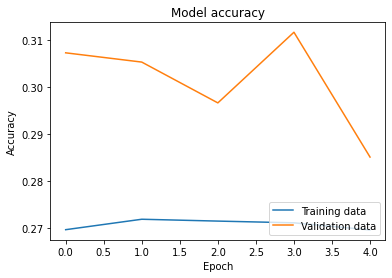

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim(0, 1)
plt.legend(['Training data', 'Validation data'], loc='lower right')
plt.show()

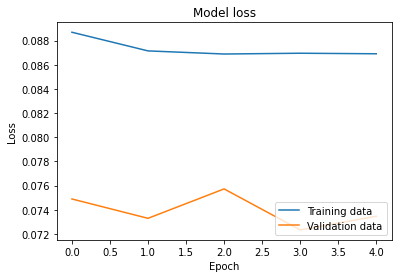

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.legend(['Training data', 'Validation data'], loc='lower right')
plt.show()

In [25]:
score = model.evaluate(x_test, y_test)

429/429 [==============================] - 1s 2ms/step - loss: 0.0735 - accuracy: 0.2852


(88, 2896)
(88, 2896)


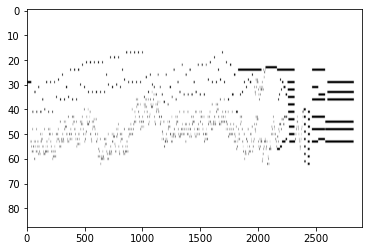

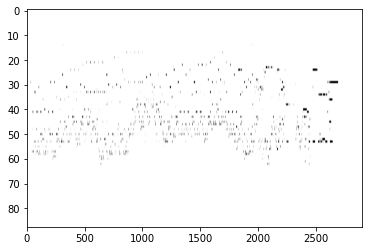

In [26]:
x = np.load(PATH_TEST_DATA+"2303"+ ".npy" ).transpose()
y = np.load(PATH_TEST_LABELS+"2303"+ ".npy" )

prediction = model.predict(x).round().transpose()
truth = y.transpose()

print(prediction.shape)
print(truth.shape)

end_seconds = 100
end_index = round(end_seconds/(0.032))

plt.figure()
plt.subplot()
plt.imshow(truth[:,0:end_index],cmap='Greys',aspect='auto')

plt.figure()
plt.subplot()
plt.imshow(prediction[:,0:end_index],cmap='Greys',aspect='auto')